In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'

genome_scores = data_dir + 'genome_scores.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'

genomes_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')
genome_score_movies = genomes_df.index.values
ratings_df = pd.read_csv(ratings, usecols=range(3), dtype={'userId':np.int64, 'movieId':np.int64, 'rating':np.float64}, low_memory=False)
ratings_df = ratings_df[ratings_df['movieId'].isin(genome_score_movies)]
ratings_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
5,1,112,3.5
6,1,151,4.0
7,1,223,4.0
8,1,253,4.0
9,1,260,4.0


In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
    
def get_users_best_silhouette_score(user_id, genome_scores_df):
    user_movie_tags_df = pd.DataFrame()
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    user_movie_tags_df = genome_scores_df[genome_scores_df.index.isin(user_movies)]
    n_movies = user_movie_tags_df.index.size
    
    highest_score = 0
    optimal_cluster_size = 2

    for cluster_size in range(2, n_movies-1, 1):
    #     kmeans = KMeans(n_clusters=cluster_size, random_state=random_state, n_jobs=-1).fit(user_movie_tags_df.values)
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(user_movie_tags_df.values[:n_movies])
        score = silhouette_score(user_movie_tags_df.values[:n_movies], result, metric='cosine')
#         cluster_size_silhouette_score_d[cluster_size] = score
        
        if score >= highest_score:
            highest_score = score
            optimal_cluster_size = cluster_size
    
    return highest_score, optimal_cluster_size
            
def get_best_silhouette_score_for_all_movies(genome_scores_df):
    score_history = []
    cluster_size_hist = []
    best_score = -1
    best_cluster_size = 0
    
    for cluster_size in range(2, 30, 5):
#         result = KMeans(n_clusters=cluster_size, random_state=171450, n_jobs=-1).fit_predict(genome_scores_df.values)
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(genome_scores_df.values)

        score = silhouette_score(genome_scores_df.values, result, metric='cosine')
        
        score_history.append(score)
        cluster_size_hist.append(cluster_size)
        
        if best_score < score:
            best_score = score
            best_cluster_size = cluster_size
            
    return score_history, cluster_size_hist, best_score, best_cluster_size

In [2]:
def get_all_users_mean_best_scores(genomes_df, test_users):
    plt.clf()
    score_history = list()
    optimal_cluster_size_hist = list()

    best_user = 0
    best_score = 0

    for user in test_users:
        highest_score, optimal_cluster_size = get_users_best_silhouette_score(user, genomes_df)
        score_history.append(highest_score)

        if best_score < highest_score:
            best_score = highest_score
            best_user = user

        optimal_cluster_size_hist.append(optimal_cluster_size)
    
    print('highest_score', best_score)
    print('best_user', best_user)

    return np.array(score_history).mean()

In [3]:
tag_genome_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')

def get_results_for_all_dfs(test_users):
    genome_df_list = [tag_genome_df, 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.3_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
                'threshold_0.35_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.6_float_movie_genomes_bz2',\
                'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']
    df_names = ['full_genomes', 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.3_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
                'threshold_0.35_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.6_float_movie_genomes_bz2',\
                'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']

    scores_df = pd.DataFrame()

    for index, genomes_df in enumerate(genome_df_list):
        print('processing for: ', df_names[index])
        if type(genomes_df) is str:
            genomes_df = pd.read_pickle(data_dir + 'output/' + genomes_df, compression='bz2')

        mean_best_score = get_all_users_mean_best_scores(genomes_df, test_users)
        print('mean_best_score', mean_best_score, '\n')
        ser = pd.Series()
        ser.name = df_names[index]
        ser['mean_best_score'] = mean_best_score
        scores_df = scores_df.append(ser)

    scores_df.plot(kind='barh')

processing for:  full_genomes
highest_score 0.24705195955814246
best_user 31
mean_best_score 0.17919995783051965 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.2531283509044078
best_user 31
mean_best_score 0.19346209078747054 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.23007002053097822
best_user 31
mean_best_score 0.1811625154019173 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.29221396741073485
best_user 1
mean_best_score 0.18843755282125285 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.23655784105477332
best_user 1
mean_best_score 0.17907177779016384 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.2912414763061995
best_user 1
mean_best_score 0.18228205042153559 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.26657732891080543
best_user 1
mean_best_score 0.19069306521113594 

processing f

<Figure size 432x288 with 0 Axes>

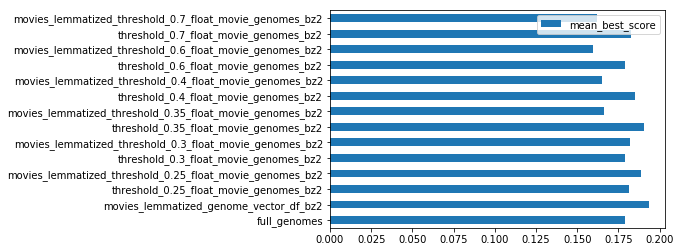

In [54]:
from time import time

test_users = list(range(1, 60, 10))

start = time()
get_results_for_all_dfs(test_users)
finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.33293630668382834
best_user 81
mean_best_score 0.21408416224629098 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.42498465578464223
best_user 81
mean_best_score 0.25418741077416634 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.34316329831587433
best_user 81
mean_best_score 0.2093355114229457 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.4283540191296153
best_user 71
mean_best_score 0.2488137112610699 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.34689392169377536
best_user 81
mean_best_score 0.2058060282550139 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.4410420383100698
best_user 71
mean_best_score 0.2503506222674428 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.34862602070659165
best_user 81
mean_best_score 0.21556747779136765 

processing 

<Figure size 432x288 with 0 Axes>

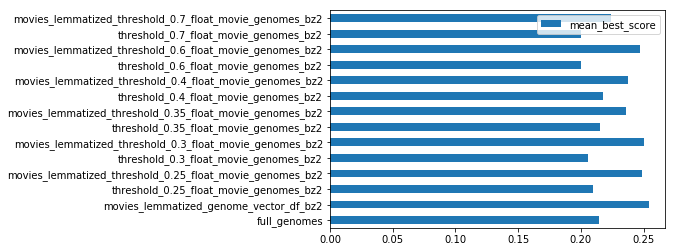

In [55]:
test_users = list(range(61, 120, 10))

start = time()
get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.25407908057933404
best_user 391
mean_best_score 0.18314398289337372 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.29586330351338885
best_user 391
mean_best_score 0.20136376132388692 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.24810628767393922
best_user 391
mean_best_score 0.18690085334002404 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.2841429624153609
best_user 391
mean_best_score 0.21057749756578606 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.2414462092951182
best_user 391
mean_best_score 0.18867924296414815 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.278955607115106
best_user 391
mean_best_score 0.20745176582414462 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.2535205651595111
best_user 391
mean_best_score 0.19457004471971165 

pro

<Figure size 432x288 with 0 Axes>

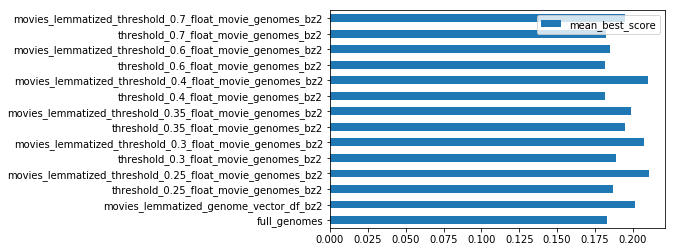

In [56]:
test_users = list(range(361, 420, 10))
start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.3661082073426605
best_user 1110
mean_best_score 0.198036975346648 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.40140226995514433
best_user 1110
mean_best_score 0.19880171133775165 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.3415886401504017
best_user 1110
mean_best_score 0.187797637347617 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.39866098617743295
best_user 1110
mean_best_score 0.18331678219563832 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.33899624933610545
best_user 1110
mean_best_score 0.18867742053918285 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.39793866299145303
best_user 1110
mean_best_score 0.17742683659742464 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.3374390023770111
best_user 1050
mean_best_score 0.19049520054743557 

<Figure size 432x288 with 0 Axes>

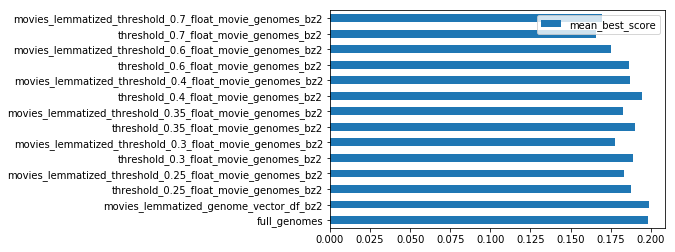

In [57]:
test_users = list(range(800, 1120, 10))
start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.3661082073426605
best_user 1110
mean_best_score 0.198036975346648 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.40140226995514433
best_user 1110
mean_best_score 0.19880171133775165 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.3415886401504017
best_user 1110
mean_best_score 0.187797637347617 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.39866098617743295
best_user 1110
mean_best_score 0.18331678219563832 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.33899624933610545
best_user 1110
mean_best_score 0.18867742053918285 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.39793866299145303
best_user 1110
mean_best_score 0.17742683659742464 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.3374390023770111
best_user 1050
mean_best_score 0.19049520054743557 

<Figure size 432x288 with 0 Axes>

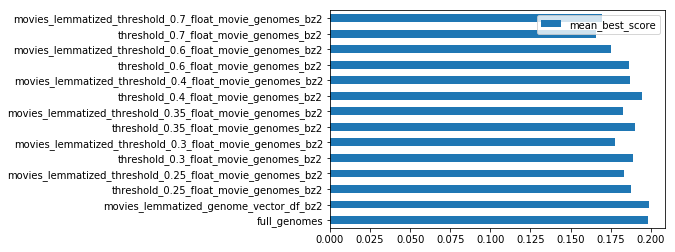

In [58]:
# file_name = 'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2'
# genomes_df = pd.read_pickle(data_dir + '/output/' + file_name, compression='bz2')
# genomes_df

known_best_users = [1110, 1050, 391, 71, 81, 41, 31, 1]

start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)